# visualisation des données

In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [ ]:
from pyquickhelper.ipythonhelper import add_notebook_menu
add_notebook_menu()

## Exercice 1 : écart entre les mariés

On reprend d'abord le code qui permet de récupérer les données.

In [ ]:
from urllib.error import URLError
import pyensae
from pyensae.datasource import dBase2df, DownloadDataException
files = ["etatcivil2012_nais2012_dbase.zip",
         "etatcivil2012_dec2012_dbase.zip",
         "etatcivil2012_mar2012_dbase.zip" ]

try:
    pyensae.download_data(files[-1], 
                          website='http://telechargement.insee.fr/fichiersdetail/etatcivil2012/dbase/')
except (DownloadDataException, URLError, TimeoutError):
    # backup plan
    pyensae.download_data(files[-1], website="xd")

df = dBase2df("mar2012.dbf")
print(df.shape, df.columns)
df.head()

(246123, 16) Index(['AMAR', 'ANAISF', 'ANAISH', 'DEPDOM', 'DEPMAR', 'DEPNAISF', 'DEPNAISH',
       'ETAMATF', 'ETAMATH', 'INDNATF', 'INDNATH', 'JSEMAINE', 'MMAR',
       'NBENFCOM', 'TUCOM', 'TUDOM'],
      dtype='object')


,AMAR,ANAISF,ANAISH,DEPDOM,DEPMAR,DEPNAISF,DEPNAISH,ETAMATF,ETAMATH,INDNATF,INDNATH,JSEMAINE,MMAR,NBENFCOM,TUCOM,TUDOM
0,2012,1984,1982,99,29,99,75,1,1,2,1,1,01,N,,9
1,2012,1969,1956,99,75,99,69,4,4,2,2,3,01,N,,9
2,2012,1992,1982,99,34,99,99,1,1,1,2,5,01,N,,9
3,2012,1987,1985,99,13,84,99,1,1,1,2,4,01,N,,9
4,2012,1963,1968,99,26,99,99,1,1,2,2,6,01,N,,9


Puis on effectue les opérations suggérées par l'énoncé.

In [ ]:
df["ANAISH"] = df.apply (lambda r:  int(r["ANAISH"]), axis=1)
df["ANAISF"] = df.apply (lambda r:  int(r["ANAISF"]), axis=1)
df["differenceHF"] = df.ANAISH - df.ANAISF
df["nb"] = 1
dist = df[["nb","differenceHF"]].groupby("differenceHF", as_index=False).count()
import pandas
pandas.concat([dist.head(n=2), dist.tail(n=3)])

,differenceHF,nb
0,-59,6
1,-56,1
97,50,1
98,56,1
99,59,1


## Exercice 2 : graphe de la distribution avec pandas

L'exemple est suggéré par le paragraphe : [bar plots](http://pandas.pydata.org/pandas-docs/stable/visualization.html#bar-plots).

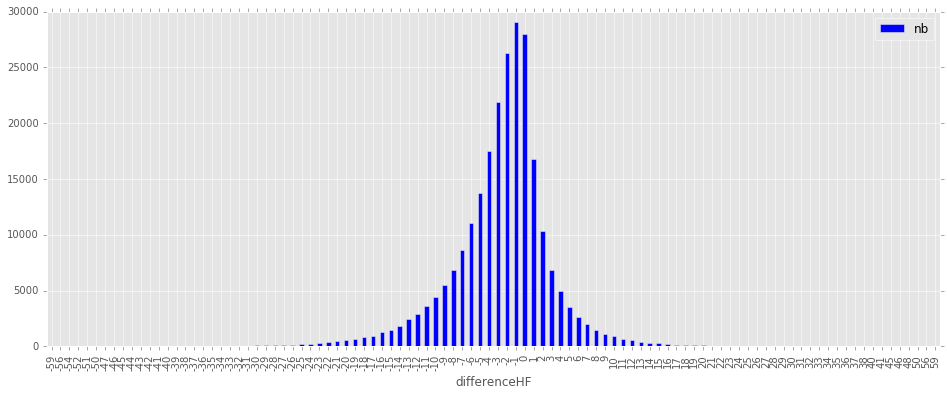

In [ ]:
dist.plot (kind="bar", y="nb", x="differenceHF", figsize=(16,6))

Mais on pouvait directement dessiner la distribution sans passer par un ``group by`` comme suggérée par le paragraphe [histograms](http://pandas.pydata.org/pandas-docs/stable/visualization.html#histograms).

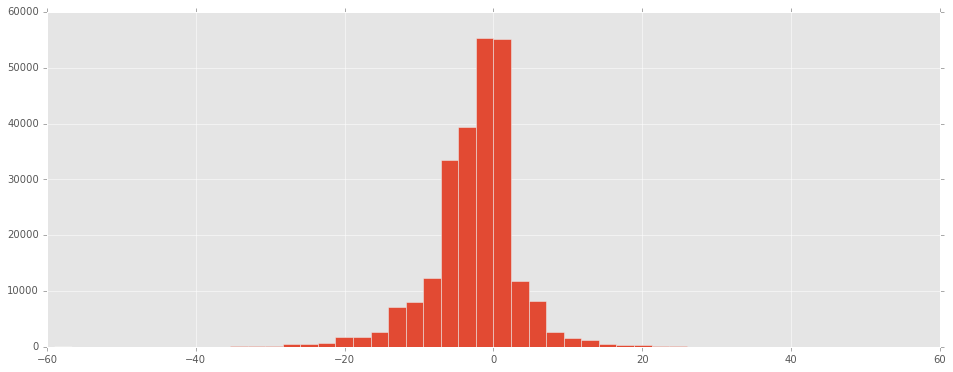

In [ ]:
df["differenceHF"].hist(figsize=(16,6), bins=50)

Ou encore la distribution lissée (voir [density plot](http://pandas.pydata.org/pandas-docs/stable/visualization.html#density-plot)) (cela prend une minute environ) :

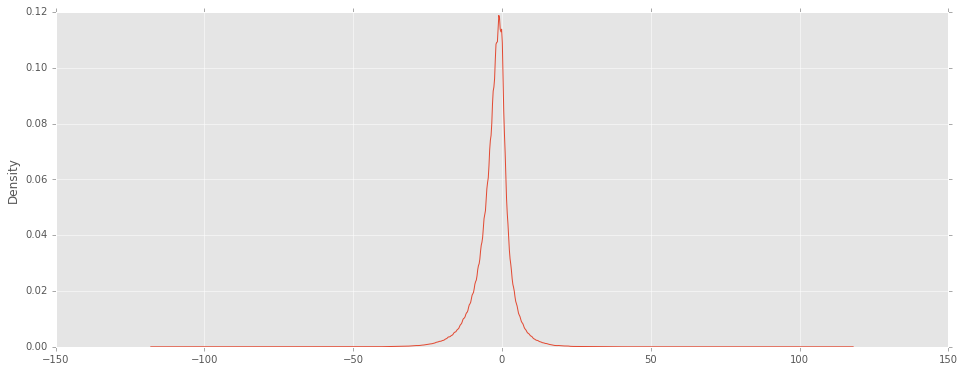

In [ ]:
df["differenceHF"].plot(figsize=(16,6), kind="kde")

Le second graphique peut être obtenu en écrivant :

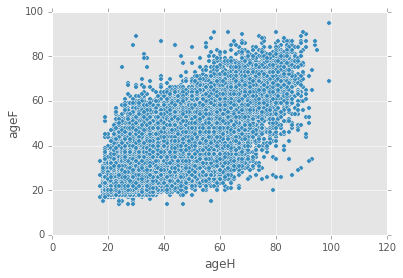

In [ ]:
df["ageH"] = -df.ANAISH + 2012
df["ageF"] = -df.ANAISF + 2012
df.plot(x="ageH", y="ageF", kind="scatter")

Il y a trop de points pour que cela soit lisible. C'est pourquoi, on utilise souvent une [heatmap](http://pandas.pydata.org/pandas-docs/stable/visualization.html#hexagonal-bin-plot).

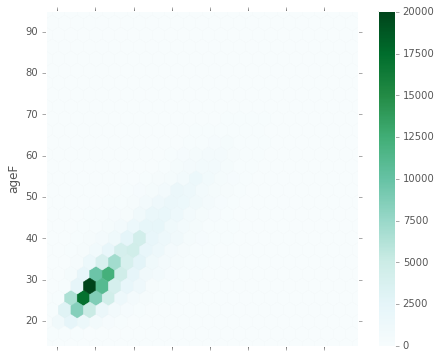

In [ ]:
df.plot(kind='hexbin', x="ageH", y="ageF", gridsize=25, figsize=(7,6))

## Exercice 3 : distribution des mariages par jour

On veut obtenir un graphe qui contient l'histogramme de la distribution du nombre de mariages par jour de la semaine et d'ajouter une seconde courbe correspond avec un second axe à la répartition cumulée.

https://github.com/pydata/pandas/issues/11111

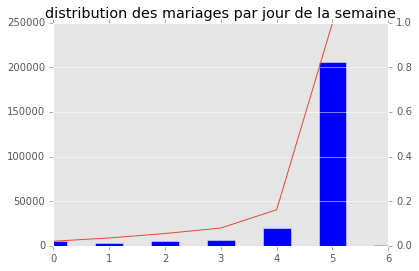

In [ ]:
# ce code échoue pour pandas 0.17.rc1, prendre 0.16.2 ou 0.17.rc2
df["nb"] = 1
dissem = df[["JSEMAINE","nb"]].groupby("JSEMAINE",as_index=False).sum()
total = dissem["nb"].sum()
repsem = dissem.cumsum() 
repsem["nb"] /= total

ax = dissem["nb"].plot(kind="bar")
repsem["nb"].plot(ax=ax, secondary_y=True)
ax.set_title("distribution des mariages par jour de la semaine")

## Exercice 4 : même graphique avec ggplot

La logique de [ggplot](https://github.com/yhat/ggplot) est légèrement différente. On ne peut pas ajouter différentes courbes provenant de plusieurs tables sur le même graphique, il faut toutes les données qu'on veut tracer dans la même table avec une colonne indiquant le nom de la courbe.

In [ ]:
df["nb"] = 1
dissem = df[["JSEMAINE","nb"]].groupby("JSEMAINE",as_index=False).sum()
dissem["nom"] = "distribution"

total = dissem["nb"].sum()
repsem = dissem.cumsum() 
repsem["nb"] /= total
repsem["JSEMAINE"] = dissem["JSEMAINE"]
repsem["nom"] = "répartition"

import pandas
cc = pandas.concat( [ dissem, repsem ] )
cc

,JSEMAINE,nb,nom
0,1,5060,distribution
1,2,3596,distribution
2,3,4876,distribution
3,4,6071,distribution
4,5,20167,distribution
5,6,205911,distribution
6,7,442,distribution
0,1,0.0205588,répartition
1,2,0.0351694,répartition
2,3,0.0549806,répartition


Une fois ceci fait, on peut utiliser ``ggplot`` et tracer la courbe.

c:\python34_x64\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
c:\python34_x64\lib\site-packages\ggplot\ggplot.py:200: RuntimeWarning: Facetting is currently not supported with geom_bar. See
                    https://github.com/yhat/ggplot/issues/196 for more information
  warnings.warn(msg, RuntimeWarning)
c:\python34_x64\lib\site-packages\ggplot\geoms\geom_bar.py:47: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  _reset = self.bottom == None or (self.ax != None and self.ax != ax)


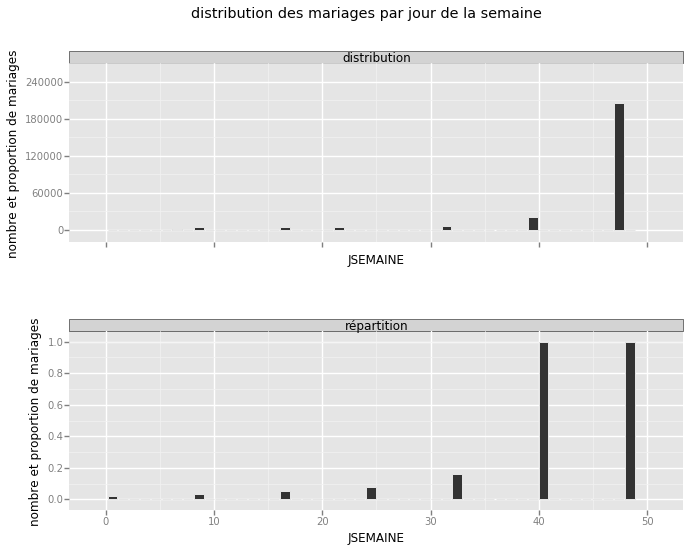

<ggplot: (15106480)>

In [ ]:
from ggplot import *
ggplot(aes(x='JSEMAINE', weight='nb'), data=cc) + \
    geom_bar() + \
    ylab("nombre et proportion de mariages") + \
    facet_wrap("nom", scales="free_y") + \
    ggtitle("distribution des mariages par jour de la semaine")

Sans changer le code du premier graphique, juste le style, il est possible d'utiliser matplotlib pour tracer les mêmes graphiques. Il est toujours plus simple d'utiliser un module déjà connu. Ceci n'est disponible qu'avec la [version 1.4](http://matplotlib.org/users/whats_new.html#style-package-added).

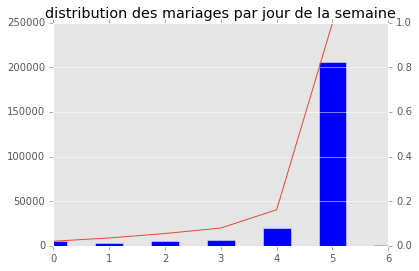

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

df["nb"] = 1
dissem = df[["JSEMAINE","nb"]].groupby("JSEMAINE",as_index=False).sum()
total = dissem["nb"].sum()
repsem = dissem.cumsum() 
repsem["nb"] /= total

ax = dissem["nb"].plot(kind="bar")
repsem["nb"].plot(ax=ax, secondary_y=True)
ax.set_title("distribution des mariages par jour de la semaine")

## Exercice 5 : dessin d'un graphe avec networkx

On construit un graphe aléatoire, ses 20 arcs sont obtenus en tirant 20 fois deux nombres entiers entre 1 et 10.  Chaque arc doit avoir une épaisseur aléatoire. 

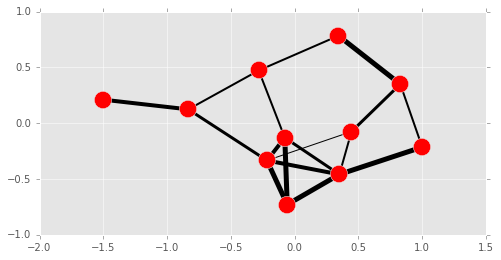

In [ ]:
import random
import networkx as nx
G=nx.Graph()
edge_width = [ ]
for i in range(20) :
    G.add_edge ( random.randint(0,10),  random.randint(0,10) )
    edge_width.append( random.randint( 1,5) )
    
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(8,4))

pos=nx.spring_layout(G) 
nx.draw_networkx_nodes(G,pos)
nx.draw_networkx_edges(G,pos,width=edge_width,ax=ax)